# DEA Coastlines vector statistics <img align="right" src="https://github.com/GeoscienceAustralia/dea-notebooks/raw/develop/Supplementary_data/dea_logo.jpg">

This code conducts vector subpixel coastline extraction for DEA Coastlines:

* Apply morphological extraction algorithms to mask annual median composite rasters to a valid coastal region
* Extract waterline vectors using subpixel waterline extraction ([Bishop-Taylor et al. 2019b](https://doi.org/10.3390/rs11242984))
* Compute rates of coastal change at every 30 m along Australia's non-rocky coastlines using linear regression

This is an interactive version of the code intended for prototyping; to run this analysis at scale, use the [`deacoastlines_statistics.py`](deacoastlines_statistics.py) Python script.

**Compatability:**
```
module use /g/data/v10/public/modules/modulefiles
module load dea/20200713
pip install --user ruptures
pip install --user git+https://github.com/mattijn/topojson/
```
---

### Load packages

First we import all required Python packages, and then start the vector coastline extraction process.

In [3]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import deacoastlines_statistics as deacl_stats

import os
import sys
import geopandas as gpd
from shapely.geometry import box
from rasterio.transform import array_bounds
import pandas as pd
import shutil
import matplotlib.pyplot as plt


## Load in data

In [ ]:
# Read in contours
study_area = 1980
output_name = 'v1.1.0'
water_index = 'mndwi'
index_threshold = 0.00
baseline_year = '2019'


## Load DEA CoastLines rasters

In [ ]:
yearly_ds, gapfill_ds = deacl_stats.load_rasters(output_name, 
                                                 study_area, 
                                                 water_index)
print(yearly_ds)

# Create output vector folder
output_dir = f'output_data/{study_area}_{output_name}/vectors'
os.makedirs(f'{output_dir}/shapefiles', exist_ok=True)

## Load vector data

In [ ]:
# Get bounding box to load data for
bbox = gpd.GeoSeries(box(*array_bounds(height=yearly_ds.sizes['y'],
                                       width=yearly_ds.sizes['x'],
                                       transform=yearly_ds.transform)),
                     crs=yearly_ds.crs)

# Rocky shore mask
smartline_gdf = (gpd.read_file('input_data/Smartline.gdb', 
                               bbox=bbox).to_crs(yearly_ds.crs))

# Tide points
tide_points_gdf = (gpd.read_file('input_data/tide_points_coastal.geojson', 
                            bbox=bbox).to_crs(yearly_ds.crs))

# Study area polygon
comp_gdf = (gpd.read_file('input_data/50km_albers_grid_clipped.geojson', 
                          bbox=bbox)
            .set_index('id')
            .to_crs(str(yearly_ds.crs)))

# Mask to study area
study_area_poly = comp_gdf.loc[study_area]

# Load climate indices
climate_df = pd.read_csv('input_data/soi.long.data', 
                         header=None, 
                         delimiter='  ', 
                         skiprows=1, 
                         index_col=0, 
                         skipfooter=10,
                         engine='python').mean(axis=1).to_frame('soi')


## Extract shoreline contours

### Extract ocean-masked contours

In [ ]:
# Generate waterbody mask
waterbody_array = deacl_stats.waterbody_mask(
    input_data='input_data/SurfaceHydrologyPolygonsRegional.gdb',
    modification_data='input_data/estuary_mask_modifications.geojson',
    bbox=bbox,
    yearly_ds=yearly_ds)

In [ ]:
# Mask dataset to focus on coastal zone only
masked_ds = deacl_stats.contours_preprocess(
    yearly_ds,
    gapfill_ds,
    water_index,
    index_threshold,
    waterbody_array,
    tide_points_gdf,
    output_path=f'output_data/{study_area}_{output_name}')

In [ ]:
# Extract contours
contours_gdf = (deacl_stats.subpixel_contours(da=masked_ds,
                                              z_values=index_threshold,
                                              min_vertices=30,
                                              dim='year',
                                              output_path='temp.geojson')
                .set_index('year'))

## Compute statistics
### Create stats points on baseline contour

In [ ]:
# Extract statistics modelling points along baseline contour
points_gdf = deacl_stats.points_on_line(contours_gdf, 
                                        baseline_year, 
                                        distance=30)

# Clip to remove rocky shoreline points
points_gdf = deacl_stats.rocky_shores_clip(points_gdf, 
                                           smartline_gdf, 
                                           buffer=50)


### Measure annual coastline movements

In [ ]:
if points_gdf is not None:  

    # Calculate annual movements and residual tide heights for every 
    # contour compared to the baseline year
    points_gdf = deacl_stats.annual_movements(points_gdf,
                                              contours_gdf,
                                              yearly_ds,                                     
                                              baseline_year,
                                              water_index)

### Calculate regressions

In [ ]:
if points_gdf is not None:

    # Apply regression function to each row in dataset
    points_gdf = deacl_stats.calculate_regressions(points_gdf,
                                                   contours_gdf,
                                                   climate_df)
    
# Add in retreat/growth helper columns (used for web services)
points_gdf['retreat'] = points_gdf.rate_time < 0 
points_gdf['growth'] = points_gdf.rate_time > 0

# Add Shoreline Change Envelope (SCE), Net Shoreline Movement 
# (NSM) and Max/Min years
stats_list = ['sce', 'nsm', 'max_year', 'min_year', 'breaks']
points_gdf[stats_list] = points_gdf.apply(
    lambda x: deacl_stats.all_time_stats(x), axis=1)

## Export files

### Export stats files

In [ ]:
if points_gdf is not None:
    
    # Set up scheme to optimise file size
    schema_dict = {key: 'float:8.2' for key in points_gdf.columns
                   if key != 'geometry'}
    schema_dict.update({'sig_time': 'float:8.3',
                        'outl_time': 'str:80',
                        'sig_soi': 'float:8.3',
                        'outl_soi': 'str:80',
                        'retreat': 'bool', 
                        'growth': 'bool',
                        'max_year': 'int:4',
                        'min_year': 'int:4',
                        'breaks': 'str:80'})
    col_schema = schema_dict.items()

    # Clip stats to study area extent, remove rocky shores
    stats_path = f'{output_dir}/stats_{study_area}_{output_name}_{water_index}_{index_threshold:.2f}'
    points_gdf = points_gdf[points_gdf.intersects(study_area_poly['geometry'])]

    # Export to GeoJSON
    points_gdf.to_crs('EPSG:4326').to_file(f'{stats_path}.geojson', 
                                           driver='GeoJSON')

    # Export as ESRI shapefiles
    stats_path = stats_path.replace('vectors', 'vectors/shapefiles')
    points_gdf.to_file(f'{stats_path}.shp',
                       schema={'properties': col_schema,
                               'geometry': 'Point'})

### Export contours

In [ ]:
# Assign certainty to contours based on underlying masks
contours_gdf = deacl_stats.contour_certainty(
    contours_gdf, 
    output_path=f'output_data/{study_area}_{output_name}')

# # Clip annual shoreline contours to study area extent
# contour_path = f'{output_dir}/contours_{study_area}_{output_name}_' \
#                f'{water_index}_{index_threshold:.2f}'
# contours_gdf['geometry'] = contours_gdf.intersection(study_area_poly['geometry'])
# contours_gdf.reset_index().to_crs('EPSG:4326').to_file(f'{contour_path}.geojson', 
#                                                        driver='GeoJSON')

# # Export stats and contours as ESRI shapefiles
# contour_path = contour_path.replace('vectors', 'vectors/shapefiles')
# contours_gdf.reset_index().to_file(f'{contour_path}.shp')

In [ ]:
# Assign certainty to contours based on underlying masks
vector_mask = deacl_stats.contour_certainty(
    contours_gdf, 
    output_path=f'output_data/{study_area}_{output_name}')

In [ ]:
vector_mask.geometry.buffer(0).is_valid

In [ ]:
gdf.plot(column='certainty')

In [ ]:
import topojson as tp
import geopandas as gpd
import json

# Load JSON geometry
json_string = '{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {"certainty": 4}, "geometry": {"type": "Polygon", "coordinates": [[[380565.0, -3576915.0], [380595.0, -3576915.0], [380595.0, -3576945.0], [380625.0, -3576945.0], [380625.0, -3576975.0], [380595.0, -3576975.0], [380595.0, -3577005.0], [380565.0, -3577005.0], [380565.0, -3577035.0], [380595.0, -3577035.0], [380595.0, -3577065.0], [380625.0, -3577065.0], [380625.0, -3577095.0], [380655.0, -3577095.0], [380655.0, -3577065.0], [380685.0, -3577065.0], [380685.0, -3577035.0], [380745.0, -3577035.0], [380745.0, -3577065.0], [380775.0, -3577065.0], [380775.0, -3577095.0], [380895.0, -3577095.0], [380895.0, -3577125.0], [380865.0, -3577125.0], [380865.0, -3577215.0], [380835.0, -3577215.0], [380835.0, -3577245.0], [380805.0, -3577245.0], [380805.0, -3577215.0], [380745.0, -3577215.0], [380745.0, -3577245.0], [380685.0, -3577245.0], [380685.0, -3577215.0], [380625.0, -3577215.0], [380625.0, -3577245.0], [380595.0, -3577245.0], [380595.0, -3577185.0], [380565.0, -3577185.0], [380565.0, -3577125.0], [380535.0, -3577125.0], [380535.0, -3577005.0], [380505.0, -3577005.0], [380505.0, -3576945.0], [380535.0, -3576945.0], [380565.0, -3576945.0], [380565.0, -3576915.0]]]}}, {"id": "1", "type": "Feature", "properties": {"certainty": 4}, "geometry": {"type": "Polygon", "coordinates": [[[380685.0, -3577335.0], [380715.0, -3577335.0], [380715.0, -3577365.0], [380745.0, -3577365.0], [380745.0, -3577395.0], [380715.0, -3577395.0], [380715.0, -3577425.0], [380685.0, -3577425.0], [380685.0, -3577395.0], [380655.0, -3577395.0], [380655.0, -3577365.0], [380685.0, -3577365.0], [380685.0, -3577335.0]]]}}, {"id": "2", "type": "Feature", "properties": {"certainty": 4}, "geometry": {"type": "Polygon", "coordinates": [[[380865.0, -3577395.0], [380895.0, -3577395.0], [380895.0, -3577425.0], [380925.0, -3577425.0], [380925.0, -3577455.0], [380895.0, -3577455.0], [380895.0, -3577485.0], [380835.0, -3577485.0], [380835.0, -3577425.0], [380865.0, -3577425.0], [380865.0, -3577395.0]]]}}, {"id": "3", "type": "Feature", "properties": {"certainty": 4}, "geometry": {"type": "Polygon", "coordinates": [[[381075.0, -3577965.0], [381195.0, -3577965.0], [381195.0, -3578025.0], [381165.0, -3578025.0], [381165.0, -3578055.0], [381135.0, -3578055.0], [381105.0, -3578055.0], [381105.0, -3578085.0], [381075.0, -3578085.0], [381075.0, -3578115.0], [381045.0, -3578115.0], [381045.0, -3578145.0], [381015.0, -3578145.0], [381015.0, -3578115.0], [380985.0, -3578115.0], [380985.0, -3578145.0], [380955.0, -3578145.0], [380955.0, -3578115.0], [380925.0, -3578115.0], [380925.0, -3578145.0], [380865.0, -3578145.0], [380865.0, -3578115.0], [380835.0, -3578115.0], [380835.0, -3578085.0], [380805.0, -3578085.0], [380805.0, -3577995.0], [380835.0, -3577995.0], [380835.0, -3578025.0], [380865.0, -3578025.0], [380865.0, -3578055.0], [380895.0, -3578055.0], [380895.0, -3578085.0], [380985.0, -3578085.0], [380985.0, -3578055.0], [381015.0, -3578055.0], [381015.0, -3578025.0], [381045.0, -3578025.0], [381045.0, -3577995.0], [381075.0, -3577995.0], [381075.0, -3577965.0]]]}}, {"id": "4", "type": "Feature", "properties": {"certainty": 4}, "geometry": {"type": "Polygon", "coordinates": [[[381255.0, -3578085.0], [381315.0, -3578085.0], [381315.0, -3578115.0], [381345.0, -3578115.0], [381345.0, -3578145.0], [381315.0, -3578145.0], [381285.0, -3578145.0], [381285.0, -3578175.0], [381255.0, -3578175.0], [381255.0, -3578145.0], [381225.0, -3578145.0], [381225.0, -3578115.0], [381255.0, -3578115.0], [381255.0, -3578085.0]]]}}, {"id": "5", "type": "Feature", "properties": {"certainty": 0}, "geometry": {"type": "Polygon", "coordinates": [[[381500.0, -3578500.0], [380400.0, -3578500.0], [380400.0, -3576500.0], [381500.0, -3576500.0], [381500.0, -3578500.0]], [[381285.0, -3578145.0], [381315.0, -3578145.0], [381345.0, -3578145.0], [381345.0, -3578115.0], [381315.0, -3578115.0], [381315.0, -3578085.0], [381255.0, -3578085.0], [381255.0, -3578115.0], [381225.0, -3578115.0], [381225.0, -3578145.0], [381255.0, -3578145.0], [381255.0, -3578175.0], [381285.0, -3578175.0], [381285.0, -3578145.0]], [[380805.0, -3577995.0], [380805.0, -3578085.0], [380835.0, -3578085.0], [380835.0, -3578115.0], [380865.0, -3578115.0], [380865.0, -3578145.0], [380925.0, -3578145.0], [380925.0, -3578115.0], [380955.0, -3578115.0], [380955.0, -3578145.0], [380985.0, -3578145.0], [380985.0, -3578115.0], [381015.0, -3578115.0], [381015.0, -3578145.0], [381045.0, -3578145.0], [381045.0, -3578115.0], [381075.0, -3578115.0], [381075.0, -3578085.0], [381105.0, -3578085.0], [381105.0, -3578055.0], [381135.0, -3578055.0], [381165.0, -3578055.0], [381165.0, -3578025.0], [381195.0, -3578025.0], [381195.0, -3577965.0], [381075.0, -3577965.0], [381075.0, -3577995.0], [381045.0, -3577995.0], [381045.0, -3578025.0], [381015.0, -3578025.0], [381015.0, -3578055.0], [380985.0, -3578055.0], [380985.0, -3578085.0], [380895.0, -3578085.0], [380895.0, -3578055.0], [380865.0, -3578055.0], [380865.0, -3578025.0], [380835.0, -3578025.0], [380835.0, -3577995.0], [380805.0, -3577995.0]], [[380895.0, -3577455.0], [380925.0, -3577455.0], [380925.0, -3577425.0], [380895.0, -3577425.0], [380895.0, -3577395.0], [380865.0, -3577395.0], [380865.0, -3577425.0], [380835.0, -3577425.0], [380835.0, -3577485.0], [380895.0, -3577485.0], [380895.0, -3577455.0]], [[380565.0, -3576915.0], [380565.0, -3576945.0], [380535.0, -3576945.0], [380505.0, -3576945.0], [380505.0, -3577005.0], [380535.0, -3577005.0], [380535.0, -3577125.0], [380565.0, -3577125.0], [380565.0, -3577185.0], [380595.0, -3577185.0], [380595.0, -3577245.0], [380625.0, -3577245.0], [380625.0, -3577215.0], [380685.0, -3577215.0], [380685.0, -3577245.0], [380745.0, -3577245.0], [380745.0, -3577215.0], [380805.0, -3577215.0], [380805.0, -3577245.0], [380835.0, -3577245.0], [380835.0, -3577215.0], [380865.0, -3577215.0], [380865.0, -3577125.0], [380895.0, -3577125.0], [380895.0, -3577095.0], [380775.0, -3577095.0], [380775.0, -3577065.0], [380745.0, -3577065.0], [380745.0, -3577035.0], [380685.0, -3577035.0], [380685.0, -3577065.0], [380655.0, -3577065.0], [380655.0, -3577095.0], [380625.0, -3577095.0], [380625.0, -3577065.0], [380595.0, -3577065.0], [380595.0, -3577035.0], [380565.0, -3577035.0], [380565.0, -3577005.0], [380595.0, -3577005.0], [380595.0, -3576975.0], [380625.0, -3576975.0], [380625.0, -3576945.0], [380595.0, -3576945.0], [380595.0, -3576915.0], [380565.0, -3576915.0]], [[380655.0, -3577365.0], [380655.0, -3577395.0], [380685.0, -3577395.0], [380685.0, -3577425.0], [380715.0, -3577425.0], [380715.0, -3577395.0], [380745.0, -3577395.0], [380745.0, -3577365.0], [380715.0, -3577365.0], [380715.0, -3577335.0], [380685.0, -3577335.0], [380685.0, -3577365.0], [380655.0, -3577365.0]]]}}]}'
json_data = json.loads(json_string)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(json_data["features"])

# Construct topology and simplify (with shared_coords=False)
topo = tp.Topology(gdf, shared_coords=False, prequantize=False)
simplified_gdf = topo.toposimplify(30).to_gdf()

In [ ]:
!pip install --user git+https://github.com/mattijn/topojson/

## Generate continental summary layer

In [ ]:
from deacoastlines_summary import main

In [ ]:
main(['out', 'v1.1.3', 'v1.0.0', '0.00', False, False, 2500])

## Add Geoserver fields

### Rate of change points
`wms_abs_t`
`wms_abs_s`

`wms_conf_t`
`wms_conf_s`

In [4]:
points_gdf = gpd.read_file('releases/DEACoastlines_v1.0.0/Shapefile/DEACoastlines_ratesofchange_v1.0.0.shp')

In [ ]:
points_gdf['abs_time'] = points_gdf.rate_time.abs()
points_gdf['conf_time'] = points_gdf['se_time'] * 1.96
points_gdf['conf_soi'] = points_gdf['se_soi'] * 1.96
points_gdf.head()

In [ ]:
# Set up scheme to optimise file size
schema_dict = {key: 'float:8.2' for key in points_gdf.columns
               if key != 'geometry'}
schema_dict.update({'sig_time': 'float:8.3',
                    'outl_time': 'str:80',
                    'sig_soi': 'float:8.3',
                    'outl_soi': 'str:80',
                    'retreat': 'bool', 
                    'growth': 'bool',
                    'max_year': 'int:4',
                    'min_year': 'int:4',
                    'breaks': 'str:80',
                    'sig_time': 'float:8.3'})
col_schema = schema_dict.items()

# Export as ESRI shapefiles
points_gdf.to_file('releases/DEACoastlines_v1.0.0-beta/DEACoastlines_v1.0.0_geoserver/DEACoastLines_statistics_v1.0.0.shp',
                   schema={'properties': col_schema, 'geometry': 'Point'})

### Annual coastlines

In [ ]:
contours_gdf = gpd.read_file('releases/DEACoastlines_v1.0.0/Shapefile/DEACoastlines_annualcoastlines_v1.0.0.shp')

In [ ]:
contours_gdf.certainty.unique()

In [ ]:
contours_gdf['wms_good'] = contours_gdf.certainty == 'good'
contours_gdf['wms_tidal'] = contours_gdf.certainty == 'tidal issues'
contours_gdf['wms_nodata'] = contours_gdf.certainty == 'insufficient data'
contours_gdf['wms_aero'] = contours_gdf.certainty == 'aerosol issues'
contours_gdf.head()

In [ ]:
# Export as ESRI shapefiles
contours_gdf.to_file('releases/DEACoastlines_v1.0.0-beta/DEACoastlines_v1.0.0_geoserver/DEACoastLines_coastlines_v1.0.0.shp')

## Annual summary

In [5]:
import numpy as np
def remove_outliers(x):
    
    if x.outl_time is not None:
        columns = [f'{"dist_"}{i}' for i in x.outl_time.split(" ") if i]
        x[columns] = np.nan

    return x


points_gdf_nooutliers = points_gdf.apply(remove_outliers, axis=1)

# import dask.dataframe as dd  

# data_dd = dd.from_pandas(points_gdf, npartitions=8) 
# points_gdf_nooutliers = (data_dd.map_partitions(lambda df: df.apply(remove_outliers, axis=1), meta=np.float).compute(scheduler='processes'))




In [48]:
# filter_rows = points_gdf_nooutliers.geometry.x > 976653.74446177
subset_gdf = points_gdf_nooutliers.loc[:,
                                       points_gdf_nooutliers.columns.str.contains('dist_')]
subset_gdf.head()

,dist_1988,dist_1989,dist_1990,dist_1991,dist_1992,dist_1993,dist_1994,dist_1995,dist_1996,dist_1997,...,dist_2010,dist_2011,dist_2012,dist_2013,dist_2014,dist_2015,dist_2016,dist_2017,dist_2018,dist_2019
0,1.69,1.52,2.78,0.19,1.56,0.36,4.87,3.88,-3.47,2.85,...,1.57,3.40,0.16,0.62,0.26,0.60,1.34,2.68,0.71,0.0
1,-0.32,-0.89,0.57,-0.18,0.48,0.21,2.83,7.77,-3.15,2.89,...,-0.77,-0.11,-0.96,-0.12,-1.36,-0.18,0.41,0.47,-1.08,0.0
2,2.07,-4.45,0.11,2.18,-1.43,3.62,4.33,8.62,-4.05,4.77,...,-2.97,-0.06,2.06,3.53,-0.13,2.87,-1.83,-0.23,-1.36,0.0
3,-1.81,-3.45,-0.85,-1.60,-1.44,0.14,0.22,6.91,-2.29,3.93,...,-1.63,-0.25,3.95,0.23,-2.71,-0.58,-1.49,-1.40,-1.72,0.0
4,-4.06,-3.63,-2.88,0.57,-2.18,-1.72,1.75,6.19,-4.58,7.26,...,-3.47,-2.64,4.53,-0.67,-2.40,-0.68,-3.67,-2.62,-2.28,0.0


In [49]:
diff_gdf = subset_gdf.diff(periods=1, axis=1)
diff_gdf

,dist_1988,dist_1989,dist_1990,dist_1991,dist_1992,dist_1993,dist_1994,dist_1995,dist_1996,dist_1997,...,dist_2010,dist_2011,dist_2012,dist_2013,dist_2014,dist_2015,dist_2016,dist_2017,dist_2018,dist_2019
0,NaN,-0.17,1.26,-2.59,1.37,-1.20,4.51,-0.99,-7.35,6.32,...,1.77,1.83,-3.24,0.46,-0.36,0.34,0.74,1.34,-1.97,-0.71
1,NaN,-0.57,1.46,-0.75,0.66,-0.27,2.62,4.94,-10.92,6.04,...,-2.19,0.66,-0.85,0.84,-1.24,1.18,0.59,0.06,-1.55,1.08
2,NaN,-6.52,4.56,2.07,-3.61,5.05,0.71,4.29,-12.67,8.82,...,-5.97,2.91,2.12,1.47,-3.66,3.00,-4.70,1.60,-1.13,1.36
3,NaN,-1.64,2.60,-0.75,0.16,1.58,0.08,6.69,-9.20,6.22,...,0.43,1.38,4.20,-3.72,-2.94,2.13,-0.91,0.09,-0.32,1.72
4,NaN,0.43,0.75,3.45,-2.75,0.46,3.47,4.44,-10.77,11.84,...,0.37,0.83,7.17,-5.20,-1.73,1.72,-2.99,1.05,0.34,2.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754797,NaN,-3.38,-2.98,-0.41,0.81,0.29,4.55,-0.19,0.47,-2.76,...,0.83,5.48,-14.48,3.02,3.10,0.48,-1.90,-0.55,3.24,-0.48
1754798,NaN,-2.50,-0.56,-1.07,-2.77,2.69,1.30,-0.83,-0.39,0.27,...,-0.48,2.90,-12.56,3.43,4.63,0.60,0.40,-0.52,1.28,1.06
1754799,NaN,-0.60,-2.24,-1.52,-0.78,1.37,1.11,-1.10,0.21,-1.40,...,0.60,2.44,-8.65,0.62,5.00,-0.04,0.29,-0.29,0.58,-0.27
1754800,NaN,2.72,-3.05,1.18,0.77,-0.25,-0.17,0.51,0.58,-2.83,...,1.33,3.53,-7.95,-2.96,7.46,-0.17,-1.20,0.44,2.90,-1.00


In [50]:
years = range(1989,2020)
thresh = 0

retreat_rates = []
growth_rates = []

for year in years:

    
    retreat_perc = (diff_gdf[f"dist_{year}"] <= -thresh).mean().item()
    growth_perc = (diff_gdf[f"dist_{year}"] >= thresh).mean().item()
    retreat_rates.append(retreat_perc)
    growth_rates.append(growth_perc)
    
#     print(f'{year} growth greater than {str(thresh)} m / year: {retreat_perc:.2%}')
#     print(f'    retreat greater than {str(thresh)} m / year: {growth_perc:.2%}')

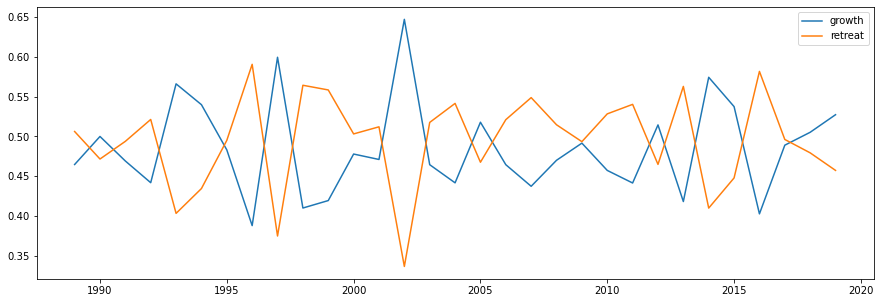

In [51]:
test = pd.DataFrame(data={'growth': growth_rates, 'retreat': retreat_rates}, index=years)  #.drop([1991, 1992, 1993, 1994])
test.plot(figsize=(15, 5))

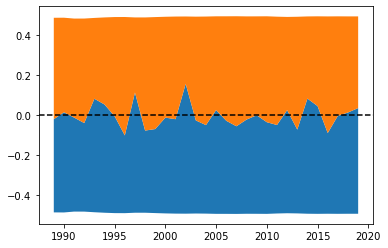

In [52]:
fig, ax = plt.subplots()
ax.stackplot(test.index, [test.growth, test.retreat], baseline='sym')
plt.axhline(0, c='black', linestyle='dashed')

(0.0, 1.0)

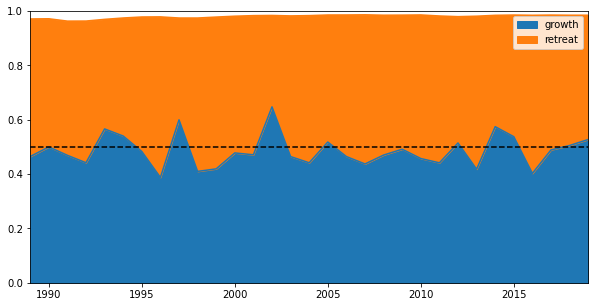

In [53]:
test.plot.area(figsize=(10, 5))
plt.axhline(0.5, c='black', linestyle='dashed')
plt.xlim([1989,2019])
plt.ylim([0, 1.0])

In [54]:
test.retreat.mean()

0.4947904424912417

In [55]:
test.growth.mean()

0.48487869102849984

In [56]:
soi = pd.read_csv('input_data/climate_indices.csv', index_col='year')
soi.head()

,SOI,IOD,SAM,IPO,PDO
year,,,,,
1987,-1.477500,0.345167,-0.149833,1.203667,1.118333
1988,0.736667,0.052417,-0.321500,-0.592417,-0.077500
1989,0.616667,-0.112833,0.640000,-0.665583,-0.551667
1990,-0.325833,-0.009167,-0.181250,-0.043083,-0.856667
1991,-1.013333,0.354500,-0.582083,0.407917,-0.933333


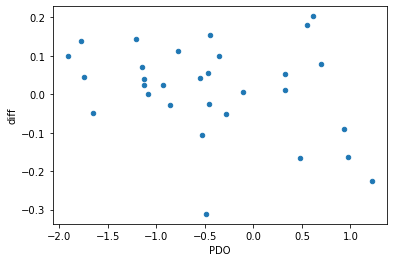

In [67]:
soi_test = test.join(soi.shift(0))
soi_test['diff'] = soi_test.retreat - soi_test.growth

soi_test.plot.scatter(x='PDO', y='diff')

In [46]:
test

,growth,retreat
1989,0.428854,0.545426
1990,0.476905,0.499892
1991,0.493992,0.480260
1992,0.438418,0.534504
1993,0.548907,0.427813
1994,0.527874,0.454799
1995,0.556425,0.426610
1996,0.377808,0.608000
1997,0.556152,0.429844
1998,0.464333,0.520036


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** For assistance with any of the Python code or Jupyter Notebooks in this repository, please post a [Github issue](https://github.com/GeoscienceAustralia/DEACoastLines/issues/new). For questions or more information about this product, sign up to the [Open Data Cube Slack](https://join.slack.com/t/opendatacube/shared_invite/zt-d6hu7l35-CGDhSxiSmTwacKNuXWFUkg) and post on the [`#dea-coastlines`](https://app.slack.com/client/T0L4V0TFT/C018X6J9HLY/details/) channel.

**Last modified:** March 2021